The principle purpose of this project is to investigate whether there are any patterns to the types of species that become endangered. As an biodiveristy analyst for National Parks Service, the goal is to ensure the survival of at risk species. This would be done through maintaining the biodiveristy of the parks. Some questions that are raised in order to achieve this are:
1. What is the distribution of conservation_status for animals?
2. Are certain types of species more likely to be endangered?
3. Are the differences between species and their conservation status significant?
4. Which species were spotted the most at each park?

In [322]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
import seaborn as sns 
%matplotlib inline

In [412]:
observations = pd.read_csv('observations.csv', encoding = 'utf-8')
species_info = pd.read_csv('species_info.csv', encoding = 'utf-8')



### The observations DataFrame has the following columns:
- **scientific_name** - The scientific name of each species
- **park_name** - The name of the national park
- **observations** - The number of observations in the past 7 days

### The species_info DataFrame has the following columns:
- **category** - The category of taxonomy for each species
- **scientific_name** - The scientific name of each species
- **common_names** - The common names of each species
- **conservation_status** - The species conservation status

Let's explore the data further by seeing what the number of unique species are.

In [331]:
print('The number of unique species in the species_info dataset is: ', species_info.scientific_name.nunique())

The number of unique species in the species_info dataset is:  5541


Now, we want to see the number of categories items in the species_info categories column

In [332]:
print('The number of categories are ', species_info.category.nunique(), ', they are as follows: ', species_info.category.unique())

The number of categories are  7 , they are as follows:  ['Mammal' 'Bird' 'Reptile' 'Amphibian' 'Fish' 'Vascular Plant'
 'Nonvascular Plant']


In [333]:
print(species_info.groupby('category').size())

category
Amphibian              80
Bird                  521
Fish                  127
Mammal                214
Nonvascular Plant     333
Reptile                79
Vascular Plant       4470
dtype: int64


Vascular plants are by far the largest category in the data, with the smallest being Reptile closely followed by Amphibian.

We'll now explore the conservation status column. 

In [334]:
print('The number of unique values in the category column is ', species_info.conservation_status.nunique(), ', they are as follows: ', species_info.conservation_status.unique())

The number of unique values in the category column is  4 , they are as follows:  [nan 'Species of Concern' 'Endangered' 'Threatened' 'In Recovery']


In [336]:
print('The number of NaN values in the data set is ', species_info.conservation_status.isna().sum())

The number of NaN values in the data set is  5633


This figure means that there are 5633 species whose status is of no concern. Let's see about the others

In [337]:
species_info.groupby('conservation_status').size()

conservation_status
Endangered             16
In Recovery             4
Species of Concern    161
Threatened             10
dtype: int64

This data tells us that those in recovery are the fewest and those of concern are the greatest.

The number of parks and the names of the parks:

In [341]:
observations.park_name.nunique()
observations.park_name.unique()

array(['Great Smoky Mountains National Park', 'Yosemite National Park',
       'Bryce National Park', 'Yellowstone National Park'], dtype=object)

What are the total number of observations in the whole observations dataset?

In [343]:
print('The total number of observations made across all species is ', observations.observations.sum())

The total number of observations made across all species is  3314739


## Now let's perfom some analysis on our data...

First we will conver the NaN values in the conservation status row to 'No Concern'.

In [349]:
species_info.fillna('No Concern', inplace=True)
species_info.groupby('conservation_status').size()

conservation_status
Endangered              16
In Recovery              4
No Concern            5633
Species of Concern     161
Threatened              10
dtype: int64

In [358]:
conservation_species = species_info[species_info.conservation_status != 'No Concern'].groupby(['conservation_status', 'category'])['scientific_name'].count().unstack()

conservation_species

category,Amphibian,Bird,Fish,Mammal,Nonvascular Plant,Reptile,Vascular Plant
conservation_status,,,,,,,
Endangered,1.0,4.0,3.0,7.0,NaN,NaN,1.0
In Recovery,NaN,3.0,NaN,1.0,NaN,NaN,NaN
Species of Concern,4.0,72.0,4.0,28.0,5.0,5.0,43.0
Threatened,2.0,NaN,4.0,2.0,NaN,NaN,2.0


By grouping the data by conservation_status and category, we can see that of the endagered species, there is 1 amphibian, 4 birds, 3 fish and 7 mammals. Of the in recovery species, there are 3 birds and 1 mammal. For the species of concern status, there are 72 birds and 28 mammals. These are by far the highest figures in the table. 

In order to be more precise with our conservation_status, I'll categorize the values. If the values are of no concern, the species is not protected. Any other category and they are considered protectd. 

In [361]:
species_info['is_protected'] = species_info.conservation_status != 'No Concern'


,category,scientific_name,common_names,conservation_status,is_protected
0,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,No Concern,False
1,Mammal,Bos bison,"American Bison, Bison",No Concern,False
2,Mammal,Bos taurus,"Aurochs, Aurochs, Domestic Cattle (Feral), Dom...",No Concern,False
3,Mammal,Ovis aries,"Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)",No Concern,False
4,Mammal,Cervus elaphus,Wapiti Or Elk,No Concern,False


In [395]:
category_count = species_info.groupby(['category', 'is_protected'])\
                            .scientific_name.nunique().reset_index()\
                            .pivot(index='category', columns='is_protected', values='scientific_name').reset_index()

category_count.columns = ['category', 'not_protected', 'protected']
category_count['percent_protected'] = category_count.protected / (category_count.not_protected + category_count.protected) * 100
category_count

,category,not_protected,protected,percent_protected
0,Amphibian,72,7,8.860759
1,Bird,413,75,15.368852
2,Fish,115,11,8.730159
3,Mammal,146,30,17.045455
4,Nonvascular Plant,328,5,1.501502
5,Reptile,73,5,6.410256
6,Vascular Plant,4216,46,1.079305


The category with the highest number of protected species is mammals, followed by birds and then amphibians
Let's plot a barchat to visualize this

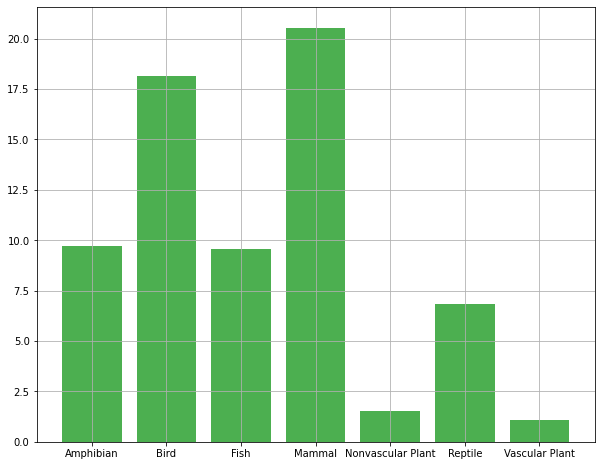

In [394]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.bar(range(len(category_count.percent_protected)), category_count.percent_protected, color = "#4CAF50")
ax.set_xticks(range(len(category_count.percent_protected)));
ax.set_xticklabels(category_count.category)
ax.grid()
plt.show()

This plot shows us that the highest proportion of protected category are the mammals. The lowest being the vascular plants. 

Now we look at statistical significance to determine whether or not, with a significance threshold of 0.05, that mammals and birds are statistically significant. 

In [410]:
from scipy.stats import chi2_contingency
contingency1 = [[30, 146], [75, 413]]
chi2, pval, dof, expected = chi2_contingency(contingency1)
print('The p value is ', pval)

The p value is  0.6875948096661336


This p value is above 0.05 (our significane threshold) and therefore they are not significant. Let's now look at reptiles and mammals.

In [411]:

contingency2 = [[5, 73], [30, 146]]

chi2, pval, dof, expected = chi2_contingency(contingency2)
print('The p value is ', pval)


The p value is  0.03835559022969898


This is below our 0.05 threshold and therefore significant. The proportion of mammals that are protected is significantly higher than reptiles

We will now look at the observations made in the last 7 days across the four parks. 


<AxesSubplot:xlabel='conservation_status', ylabel='observations'>

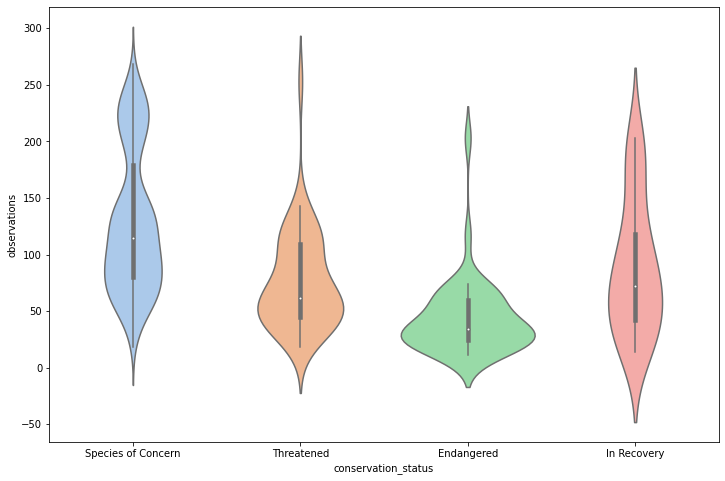

In [294]:
## plot violinplot
fig, ax = plt.subplots(figsize=(12, 8))
sns.violinplot(x = 'conservation_status', y = 'observations', data = conservation_status_df, palette = 'pastel')


The violinplot gives us a little bit more information that the previous boxplot does. It shows us that Species of Concern is bimodal, meaning it has two peaks to its distribution. The endangered species has most of its species in the 0 to 50 observations range. Curiously, those species in recovery tend to be distrubuted fairly evenly. Firstly,  let's visiualize the species of concern distribution on a histogram.

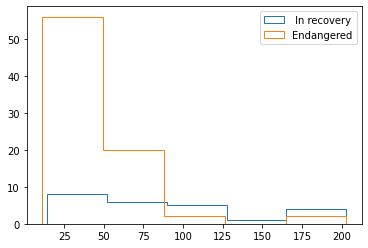

<Figure size 432x288 with 0 Axes>

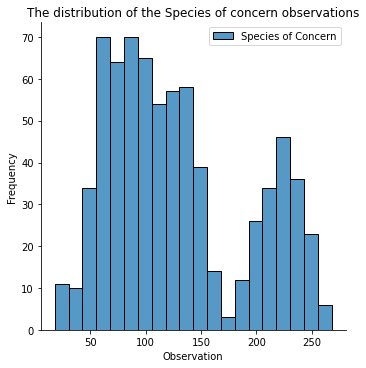

In [259]:
in_recovery = species_observations[species_observations['conservation_status'] == 'In Recovery']
endangered = species_observations[species_observations['conservation_status'] == 'Endangered']
of_concern = species_observations[species_observations['conservation_status'] == 'Species of Concern']


plt.hist(in_recovery.observations, bins=5, histtype='step', label=' In recovery');
plt.hist(endangered.observations, bins=5, histtype='step', label='Endangered');
plt.legend()
plt.show()
plt.clf()


sns.displot(of_concern.observations, bins=20, kde=False);
plt.title('The distribution of the Species of concern observations')
plt.xlabel('Observation')
plt.ylabel('Frequency')
plt.legend(['Species of Concern'])
plt.show()

This graphs tells us that the volume of endangered species is much higher thatn those in recovery. Although, those in recovery tend to be more concentrated in the lower end of observations. The species of concern are higher is frequency and the distribution is bimodal. Let's look at the types of species that are endangered to look for any trends. 

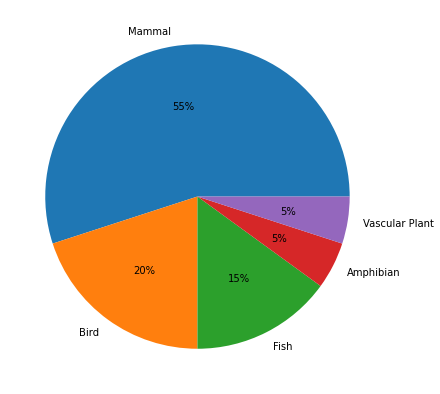

In [264]:
plt.figure(figsize=(7, 7))
labels = ['Mammal', 'Bird', 'Fish', 'Amphibian', 'Vascular Plant']
plt.pie(endangered.category.value_counts(normalize=True).values, labels=labels, autopct='%d%%');

Clearly, the majority of endangered species are mammals, with the second largest being bird followed by fish and the smallest group being vascular plants and amphibians. 




We ought to compare the difference between species and conservation status to see if there is a significant association between the two variables. Category of species is a nominal categorical variable and conservation status is an ordinal categorical variable. Given this information, the best test is a Chi-Square test. The null hypothesis is that there is no association between these two variables. The alternative hypothesis is that there is an association. I'll use a significance threshold of 5 percent.
Let's begin!

In [267]:
from scipy.stats import chi2_contingency
ab_contingency = pd.crosstab(species_observations.category, species_observations.conservation_status)
print(ab_contingency)

conservation_status  Endangered  In Recovery  Species of Concern  Threatened
category                                                                    
Amphibian                     4            0                  16           8
Bird                         16           12                 320           0
Fish                         12            0                  16          20
Mammal                       44           12                 168           8
Nonvascular Plant             0            0                  20           0
Reptile                       0            0                  20           0
Vascular Plant                4            0                 172           8


This table gives us a nice overview of our two categorical variables. The rows represent the category of the species, the columns represent the conservation_status.


Now let's test for an association. We assume that the variables are mutually exclusive. This is correct as a species cannot be in both the species of concern category and threatened category, for example. Furthermore, a species cannot belong to both fish and mammal categories. Secondly, We are also assuming that the observations are independent and random. This is the case given that the data was sampled from four different parks. 

In [268]:
chi2, pval, dof, expected = chi2_contingency(ab_contingency)
print(pval)

2.7594442674479634e-49


Given that this value is below our 0.05 significance threshold, we can conclude that there is a significant assocation between conservation_status and category of species. Finally we will look at which species were spotted most frequently at each park. 

In [295]:
most_common_by_park = species_observations.groupby('park_name').agg({'common_names': 'max'})
print(most_common_by_park)


                                     common_names
park_name                                        
Bryce National Park                  Zygodon Moss
Great Smoky Mountains National Park  Zygodon Moss
Yellowstone National Park            Zygodon Moss
Yosemite National Park               Zygodon Moss


The most common species for every park is Zygodon Moss. Let's delve deeper and find out the most common endangered mammals by park. Ranked by the fewest observations.

In [313]:
endangered_mammal = species_observations[(species_observations['category'] == 'Mammal') & (species_observations['conservation_status'] == 'Endangered')]
endangered_mammal.groupby(['park_name', 'common_names'])['observations'].min()


park_name                            common_names                                               
Bryce National Park                  Carolina Northern Flying Squirrel, Northern Flying Squirrel    29
                                     Gray Myotis                                                    27
                                     Gray Wolf                                                      27
                                     Gray Wolf, Wolf                                                27
                                     Indiana Bat, Indiana Or Social Myotis                          27
                                     Red Wolf                                                       30
                                     Sierra Nevada Bighorn Sheep                                    22
Great Smoky Mountains National Park  Carolina Northern Flying Squirrel, Northern Flying Squirrel    21
                                     Gray Myotis                               

In Bryce National Park the most endangered mammal are the Gray Myotis and the Gray Wolf. In Great Smoky Mountains National Park, it's the Gray Wolf and Indiana Bat. In Yellowstone National Park, it's the Gray Wolf and in Yosemite National Park it is the Red Wolf.

## Conclusion
From the findings, a conclusion can be made that the most common conservation status is is species of concern. The least common being 